## Port Elizabeth Crime Forecasting
### Anil Abraham 2023

#### The goal of this project is to use machine learning techniques to forecast crime in Port Elizabeth. Particularly, forecasting type of crime, number of crimes committed in a year, and crime hotspots.

### Importing libraries

In [79]:
import pandas as pd #Pandas for data manipulation and analysis
import numpy as np #Numpy for matrices
import geopandas as gpd #Support for geospatial data
from shapely.geometry import Point, Polygon #Geographic information systems functions and analysis
import matplotlib.pyplot as plt #Matplotlib for visualisations
import seaborn as sns
import plotly.express

In [80]:
#sns.set_style("darkgrid")

### Data preprocessing

In [81]:
df = pd.read_csv('crimedata.csv', thousands=',')

print(f'Null values found\n{df.isna().sum()}') #Check for null values

print(f'\n\n{df.columns}') #List all feature names

Null values found
Crime                  0
Crimes                 0
Police Station         0
Province               0
Crime Category         0
Latitude               0
Longitude              0
Latitude, Longitude    0
Year                   0
dtype: int64


Index(['Crime', 'Crimes', 'Police Station', 'Province', 'Crime Category',
       'Latitude', 'Longitude', 'Latitude, Longitude', 'Year'],
      dtype='object')


### What are the datatypes used?

In [82]:
df.dtypes

Crime                   object
Crimes                   int64
Police Station          object
Province                object
Crime Category          object
Latitude               float64
Longitude              float64
Latitude, Longitude     object
Year                     int64
dtype: object

Crimes is the *number* of crimes (of some specific type) that took place in one year. Therefore, it shouldn't be a string/object if we are to analyse number of crimes. Let's convert it to an int64

<span style="color: #FFFF00">Does 1,4 crimes in a year make sense? What should we do with this?</span>

#### What does the csv file look like?

In [83]:
df

,Crime,Crimes,Police Station,Province,Crime Category,Latitude,Longitude,"Latitude, Longitude",Year
0,Murder,5,Aberdeen,Eastern Cape,Contact Crimes,-32.476960,24.060513,"-32.4769604, 24.0605132",2010
1,Attempted murder,3,Aberdeen,Eastern Cape,Contact Crimes,-32.476960,24.060513,"-32.4769604, 24.0605132",2010
2,Assault with the intent to inflict grievous bo...,67,Aberdeen,Eastern Cape,Contact Crimes,-32.476960,24.060513,"-32.4769604, 24.0605132",2010
3,Common assault,31,Aberdeen,Eastern Cape,Contact Crimes,-32.476960,24.060513,"-32.4769604, 24.0605132",2010
4,Common robbery,2,Aberdeen,Eastern Cape,Contact Crimes,-32.476960,24.060513,"-32.4769604, 24.0605132",2010
...,...,...,...,...,...,...,...,...,...
345295,Shoplifting,210,Wynberg,Western Cape,Other Serious Crimes,-34.004107,18.464883,"-34.0041069, 18.4648833",2019
345296,Illegal possession of firearms and ammunition,8,Wynberg,Western Cape,Crime detected as a result of Police Action,-34.004107,18.464883,"-34.0041069, 18.4648833",2019
345297,Drug-related crime,581,Wynberg,Western Cape,Crime detected as a result of Police Action,-34.004107,18.464883,"-34.0041069, 18.4648833",2019
345298,Driving under the influence of alcohol or drugs,252,Wynberg,Western Cape,Crime detected as a result of Police Action,-34.004107,18.464883,"-34.0041069, 18.4648833",2019


In [84]:
df['Crime Category'].value_counts().sort_values(ascending=False)

Contact Crimes                                 69060
Aggravated Robbery                             69060
Property-Related Crimes                        57550
Sexual Offences                                46040
Crime detected as a result of Police Action    46040
Other Serious Crimes                           34530
Contact-Related Crimes                         23020
Name: Crime Category, dtype: int64

##### As we can see, most crimes committed in South Africa from 2010 - 2019 were Contact Crimes.

#### Features of crimedata.csv are:
<ul>
  <li>Crime (what crime was committed)</li>
  <li>Crimes (How many times a specific crime was committed for that year)</li>
  <li>Police Station (Which station was the crime reported to)</li>
  <li>Province</li>
  <li>Crime Category (Contact, property-related, aggravated robbery, sexual offence, etc)</li>
  <li>Latitude</li>
  <li>Longitude</li>
  <li>Latitude, Longitude</li>
  <li>Year</li>
</ul>

#### Limit provinces to only Eastern Cape

In [85]:
#df = df.drop(['Latitude, Longitude'], axis=1)
df = df[df['Province'] == 'Eastern Cape']
df.to_csv('ECcrimerates.csv', encoding='utf-8', index=False) #Create new csv file with crime information within Eastern Cape only
df_EC = pd.read_csv('ECcrimerates.csv') #Set df equal to the new cleaned CSV.

#### Let's load the SHAPE file of South Africa

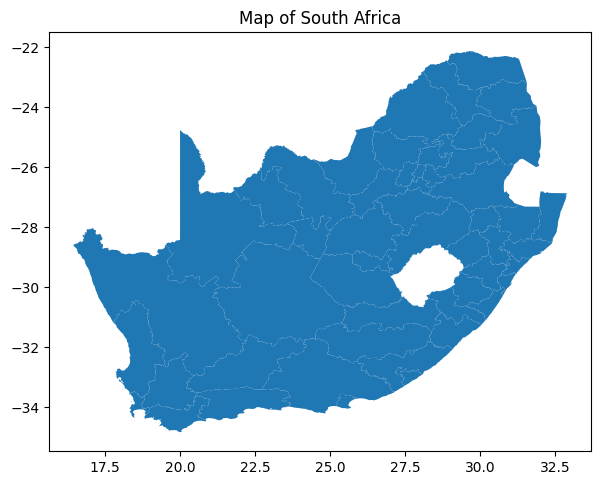

In [86]:
map = gpd.read_file("gadm41_ZAF_shp\\gadm41_ZAF_2.shp")
fig, ax = plt.subplots(figsize=(7,7))
map.plot(aspect=1,ax = ax)
plt.title('Map of South Africa')
plt.show()

#### After some careful analysis, I found out that there is some incorrect data that has been input. The Police Station 'Doringkloof' does not exist within the Eastern Cape. Doringkloof is a suburb in Gauteng. Therefore, we remove this.

In [87]:
df = df[df['Police Station'] != 'Doringkloof']
df.describe()

,Crimes,Latitude,Longitude,Year
count,58200.000000,58200.000000,58200.000000,58200.000000
mean,35.203351,-32.373939,27.089175,2014.500000
std,91.869912,1.042523,1.411054,2.872306
min,-1.000000,-34.167017,23.152191,2010.000000
25%,0.000000,-33.149218,26.085341,2012.000000
50%,5.000000,-32.569626,27.244802,2014.500000
75%,27.000000,-31.524087,28.000901,2017.000000
max,1734.000000,-30.261515,30.183881,2019.000000


#### Let's take our map of South Africa and plot all the coordinates of the police stations in the Eastern Cape only.

c:\Users\G20A2632\AppData\Local\Programs\Python\Python39\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



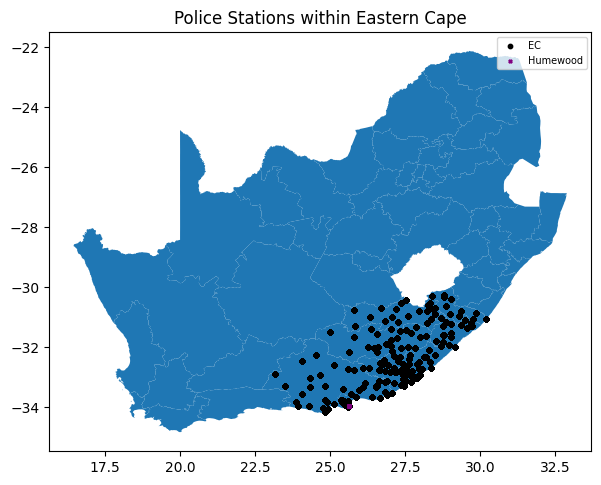

In [88]:
#A GeoDataFrame is a dataframe that accepts a geometry column (POINT pairs)
geo_df = gpd.GeoDataFrame(df, crs = {'init': 'epsg:4326'}, geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])])

fig, ax = plt.subplots(figsize=(7,7))
map.plot(aspect=1,ax=ax) #Plot the map of South Africa
geo_df.plot(aspect=1,ax=ax,markersize=10,color='black',marker='o',label='EC') #Plot the latitude longitude pairs onto the same SA map.
geo_df[geo_df['Police Station'] == 'Humewood'].plot(aspect=1,ax=ax,markersize=5,color='purple',marker='X',label='Humewood')
plt.title('Police Stations within Eastern Cape')
plt.legend(prop={'size':7})
plt.show()

#### Police stations within Port Elizabeth are:
<ul>
<li>Walmer</li>
<li>Swartkops</li>
<li>Mount Road</li>
<li>Humewood</li>
<li>Kwadwesi</li>
<li>Kabega Park</li>
<li>Algoapark</li>
<li>Gelvandale</li>
<li>Uitenhage</li>
<li>Bethelsdorp</li>
<li>Motherwell</li>
<li>New Brighton</li>
<li>Despatch</li>
<li>Kwazakele</li>
</ul>

In [89]:
stations = ["Walmer", "Swartkops", "New Brighton", "Mount Road", "Humewood", "Kwadwesi", "Kabega Park", "Algoapark", "Gelvandale", "Uitenhage", "Bethelsdorp", "Motherwell"
            , "Despatch", "Kwazakele", "Kamesh", "Kwanobuhle", "Ikamvelihle"]
df = df[df['Police Station'].isin(stations)]
df.drop(['Latitude, Longitude', 'Province', 'geometry'], axis=1, inplace=True)
df.reset_index(drop=True, inplace=True)
df.to_csv('PEcrimerates.csv', encoding='utf-8', index=False) #Create new csv file with crime information within PE only
# print(geo_df['Crime Category'].nunique())
# df.drop(['Latitude', 'Longitude', 'Crime', 'Province', 'Crime Category', 'Year'], inplace=True, axis=1)
# df = df.groupby(['Police Station'])['Crimes'].agg(Crimes='sum')
# print(df)

#### Let's plot the police stations within Port Elizabeth only.

c:\Users\G20A2632\AppData\Local\Programs\Python\Python39\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


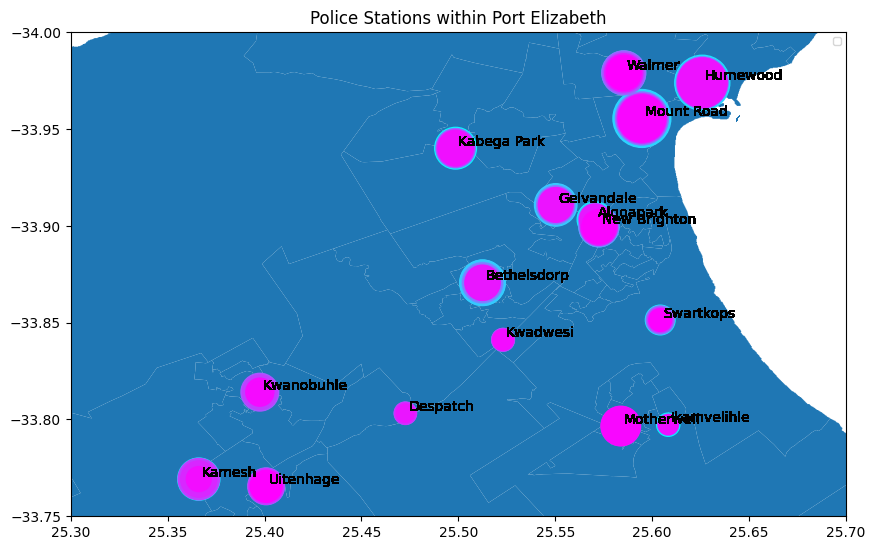

In [102]:
#A GeoDataFrame is a dataframe that accepts a geometry column (POINT pairs)
geo_df = gpd.GeoDataFrame(df, crs = {'init': 'epsg:4326'}, geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])])

fig, ax = plt.subplots(figsize=(10,10))
map = gpd.read_file("gadm41_ZAF_shp\\gadm41_ZAF_4.shp")
map.plot(aspect=1,ax=ax) #Plot the map of South Africa
geo_df['Crimes'] = geo_df['Crimes'].astype('float64')
geo_df.plot(aspect=1,ax=ax, markersize='Crimes', cmap = 'cool') #Plot the latitude longitude pairs onto the same SA map.
ax.set_ylim([-33.75, -34])
ax.set_xlim([25.3, 25.7])
plt.title('Police Stations within Port Elizabeth')
plt.legend(prop={'size':7})
for x, y, label in zip(geo_df.geometry.x, geo_df.geometry.y, geo_df['Police Station']):
    ax.annotate(label, xy=(x, y), xytext=(2, 2), textcoords="offset points")
plt.show()

In [91]:
sum_crimes = geo_df.groupby(['Police Station'])['Crimes'].sum()
sum_crimes = sum_crimes.reset_index()
sum_crimes['Latitude'] = geo_df['Latitude'].unique()
sum_crimes['Longitude'] = geo_df['Longitude'].unique()

In [92]:
import plotly.express as px

fig = px.scatter_mapbox(sum_crimes, lat="Latitude", lon="Longitude", hover_name="Police Station", hover_data=["Crimes"],
                        color="Crimes", color_continuous_scale=['Yellow', 'orange', 'red', 'maroon'], zoom=3, height=600, size='Crimes', size_max=30)
fig.update_layout(mapbox_style="carto-darkmatter")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

<span style="color: #FFFF00">Kwazakele is a police station in Port Elizabeth, but displays outside of PE. What should I do?</span>

In [93]:
geo_df

,Crime,Crimes,Police Station,Crime Category,Latitude,Longitude,Year,geometry
0,Murder,20.0,Algoapark,Contact Crimes,-33.903171,25.570496,2010,POINT (25.57050 -33.90317)
1,Attempted murder,14.0,Algoapark,Contact Crimes,-33.903171,25.570496,2010,POINT (25.57050 -33.90317)
2,Assault with the intent to inflict grievous bo...,158.0,Algoapark,Contact Crimes,-33.903171,25.570496,2010,POINT (25.57050 -33.90317)
3,Common assault,369.0,Algoapark,Contact Crimes,-33.903171,25.570496,2010,POINT (25.57050 -33.90317)
4,Common robbery,54.0,Algoapark,Contact Crimes,-33.903171,25.570496,2010,POINT (25.57050 -33.90317)
...,...,...,...,...,...,...,...,...
5095,Shoplifting,127.0,Walmer,Other Serious Crimes,-33.978868,25.585376,2019,POINT (25.58538 -33.97887)
5096,Illegal possession of firearms and ammunition,26.0,Walmer,Crime detected as a result of Police Action,-33.978868,25.585376,2019,POINT (25.58538 -33.97887)
5097,Drug-related crime,305.0,Walmer,Crime detected as a result of Police Action,-33.978868,25.585376,2019,POINT (25.58538 -33.97887)
5098,Driving under the influence of alcohol or drugs,154.0,Walmer,Crime detected as a result of Police Action,-33.978868,25.585376,2019,POINT (25.58538 -33.97887)


### Let's do some EDA

In [94]:
df_grouped = df.groupby(['Police Station'])['Crimes'].sum()
df_grouped_year = df.groupby(['Police Station', 'Year'])['Crimes'].sum()

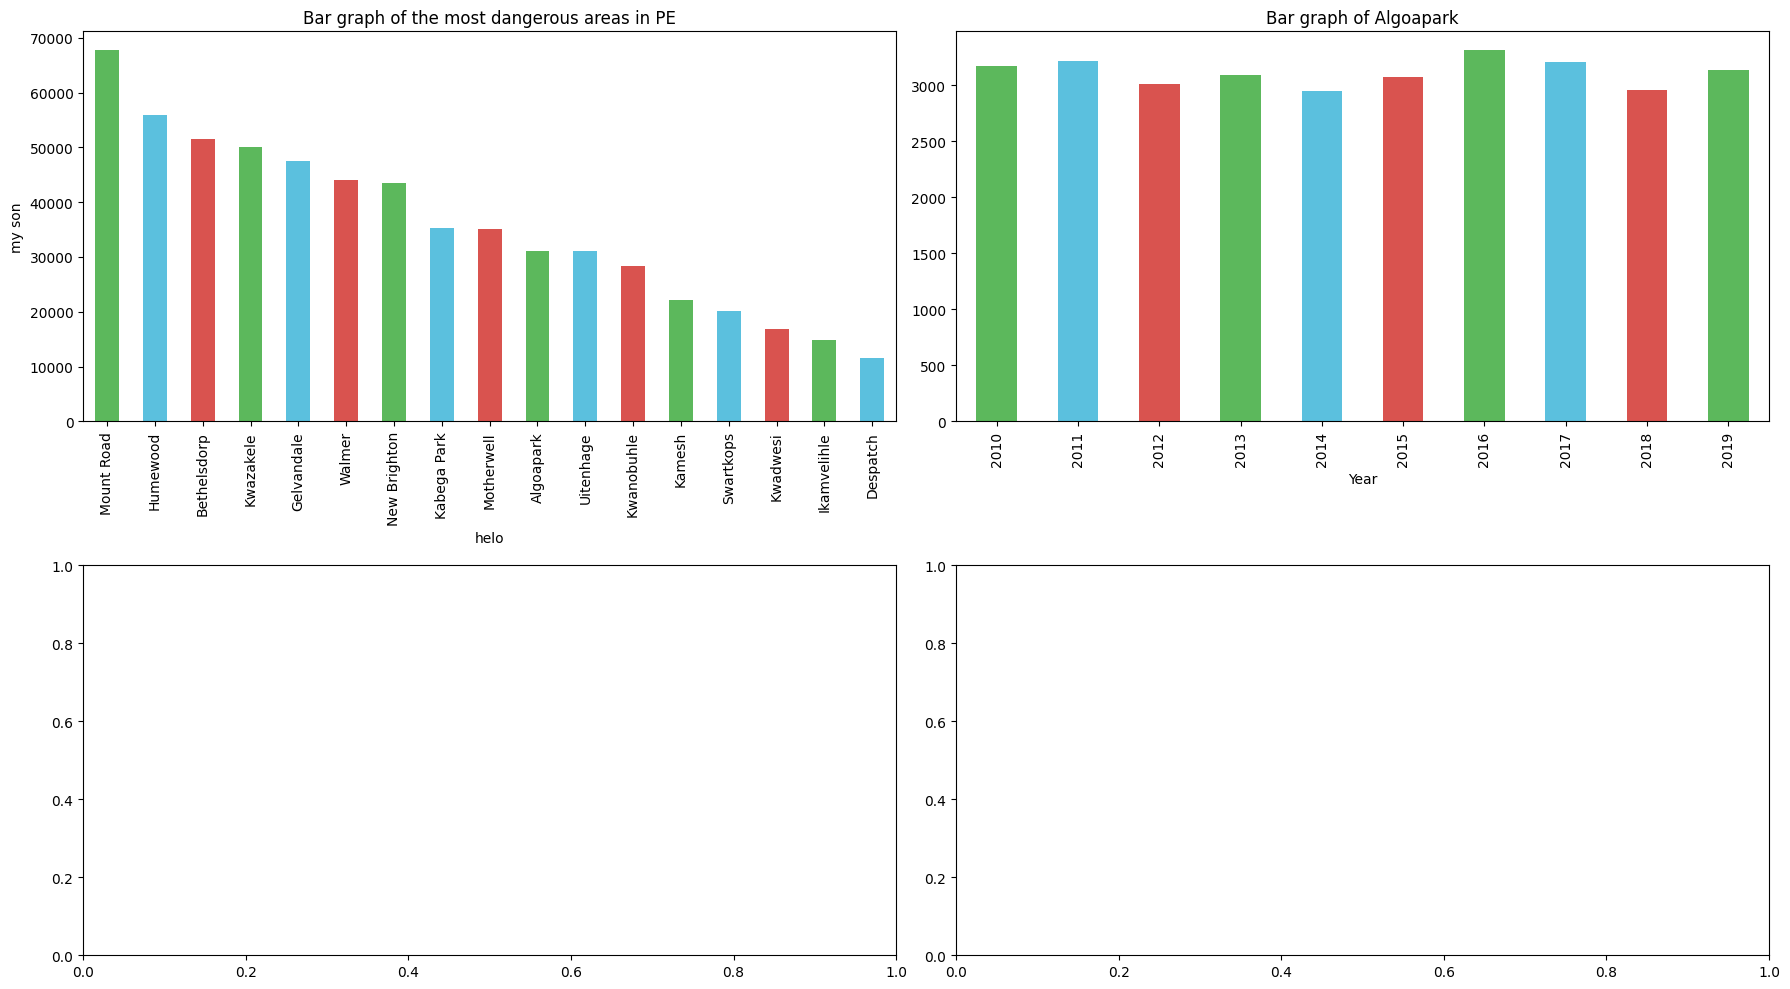

In [95]:
fig, axs = plt.subplots(2, 2, figsize=(18, 10))

df_grouped.sort_values(ascending=False).plot.bar(color=['#5cb85c','#5bc0de','#d9534f'], ax=axs[0,0])
df_grouped_year['Algoapark'].plot.bar(color=['#5cb85c','#5bc0de','#d9534f'], ax=axs[0,1])

axs[0,0].set_title('Bar graph of the most dangerous areas in PE')
axs[0,0].set_xlabel('helo')
axs[0,0].set_ylabel('my son'
                    )
axs[0,1].set_title('Bar graph of Algoapark')
plt.tight_layout()

In [96]:
df_grouped.sort_values(ascending=False)

Police Station
Mount Road      67816.0
Humewood        56020.0
Bethelsdorp     51610.0
Kwazakele       50031.0
Gelvandale      47519.0
Walmer          44071.0
New Brighton    43546.0
Kabega Park     35218.0
Motherwell      35175.0
Algoapark       31144.0
Uitenhage       31104.0
Kwanobuhle      28401.0
Kamesh          22196.0
Swartkops       20112.0
Kwadwesi        16837.0
Ikamvelihle     14836.0
Despatch        11619.0
Name: Crimes, dtype: float64

### Thanks for reading!